In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver import FirefoxOptions 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

In [231]:
url = 'https://racetozerodataexplorer.org/proceed/'

scope1_lst = []
scope2_local_lst = []
scope2_market_lst = []
name_lst = []

master_lst = [scope1_lst, scope2_local_lst, scope2_market_lst, name_lst]

options = FirefoxOptions()
options.add_argument("--headless") # comment out to see how it works

with webdriver.Firefox(options=options) as driver:
    driver.get(url)
    headers = driver.find_elements(By.XPATH, "//*[@class= 'styles_table__jWPKo']/thead/tr/th")
    headers = [header.text for header in headers]
    table = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, 'tr')
    
    for row in table:
        name = row.find_element(By.TAG_NAME, 'th')
        # print(name.text)
        master_lst[3].append(name.text)
        for i, cell in enumerate(row.find_elements(By.TAG_NAME, 'td')):
            if i in [0,1,2]: # only interested in first 3 columns
                try:
                    cell.find_element(By.CLASS_NAME, 'styles_button__IS06I').click()
                    WebDriverWait(driver, 10).until( # Wait for pop-up to load
                        EC.presence_of_element_located((By.CLASS_NAME, 'styles_axisValue__ipOq1')))
                    values = driver.find_elements(By.CLASS_NAME, 'styles_axisValue__ipOq1')
                    master_lst[i].append([value.text.replace(',','') for value in values])
                    driver.find_element(By.CLASS_NAME, 'styles_close__cpVjT').click()
                except:
                    master_lst[i].append(['', '', '', ''])

In [213]:
industries = [
    'Basic Materials',
    'Communication Services',
    'Consumer Cyclicals',
    'Consumer Discretionary',
    'Consumer Non-Cyclicals',
    'Consumer Staples',
    'Energy',
    'Health Care',
    'Industrials',
    'Information Technology',
    'Materials',
    'Real Estate',
    'Technology',
    'Utilities',
]

sectors = []

with webdriver.Firefox(options=options) as driver:
    driver.get(url)
    for industry in industries:
        filter = driver.find_element(By.ID, 'react-select-q-input')
        filter.click()
        filter.send_keys(industry)
        time.sleep(0.2)
        if industry in ['Materials', 'Technology']:
            filter.send_keys(Keys.DOWN)
        filter.send_keys(Keys.ENTER)
        time.sleep(0.2)
        table = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, 'tbody')
        names = table.find_elements(By.TAG_NAME, 'th')
        for name in names:
            sectors.append([industry, name.text])
        driver.find_element(By.CLASS_NAME, 'css-g010ao').click()
    

In [149]:
headers = [header.strip().replace('\n', ' ').replace(
    '4 years trend (ending in reporting year)', '') for header in headers]
years = ['2018', '2019', '2020', '2021']
    
# Need to merge all these 
df_scope1 = pd.DataFrame(master_lst[0], index=master_lst[3], columns=years).reset_index(drop=False)
df_scope2_loc = pd.DataFrame(master_lst[1], index=master_lst[3], columns=years).reset_index(drop=False)
df_scope2_mkt = pd.DataFrame(master_lst[2], index=master_lst[3], columns=years).reset_index(drop=False)

df_sectors = pd.DataFrame(master_lst[4], columns=['Industry'], index=master_lst[3])

NameError: name 'headers' is not defined

In [2]:
engine = create_engine("sqlite:///GDS.db")
if not database_exists(engine.url):
    create_database(engine.url)

In [20]:
# Add dataframes to database to avoid having to rerun webscraping each time
for df, header in [(df_scope1, headers[1]), (df_scope2_loc, headers[2]), (df_scope2_mkt, headers[3])]:
    df.rename(columns={'index': 'Company Name'}, inplace=True)
    df.to_sql(header.replace(' ', '_'), engine, if_exists='replace', index=False)

df_sectors.to_sql('Sectors', engine, if_exists="replace", index=False) 

NameError: name 'df_scope1' is not defined

In [4]:
df_scope1 = pd.read_sql_table('Scope_1_emissions_(tCO₂e)', engine)
df_scope2_loc = pd.read_sql_table('Scope_2_emissions_(tCO₂e)_Location', engine)
df_scope2_mkt = pd.read_sql_table('Scope_2_emissions_(tCO₂e)_Market', engine)

df_sectors = pd.read_sql_table('Sectors', engine)

In [5]:
# Drop Interpublic Group of Companies, Inc. which is duplicated in data source
df_scope1 = df_scope1.loc[~df_scope1['Company Name'].duplicated()] 
df_scope2_loc = df_scope2_loc.loc[~df_scope2_loc['Company Name'].duplicated()] 
df_scope2_mkt = df_scope2_mkt.loc[~df_scope2_mkt['Company Name'].duplicated()] 

In [6]:
# Filter out companies with no data
df_scope1 = df_scope1.loc[~df_scope1.iloc[:,1:].duplicated()]
df_scope2_loc = df_scope2_loc.loc[~df_scope2_loc.iloc[:,1:].duplicated()]
df_scope2_mkt = df_scope2_mkt.loc[~df_scope2_mkt.iloc[:,1:].duplicated()]

In [7]:
df_scope1 = df_scope1.melt(id_vars='Company Name', value_name='Scope_1_emissions_(tCO₂e)', var_name='Year')
df_scope2_loc = df_scope2_loc.melt(id_vars='Company Name', value_name='Scope_2_emissions_(tCO₂e)_Location', var_name='Year')
df_scope2_mkt = df_scope2_mkt.melt(id_vars='Company Name', value_name='Scope_2_emissions_(tCO₂e)_Market', var_name='Year')

In [4]:
companies_sample

,Company Name,Listing Status,Ticker
0,Empresas CMPC,Listed,CMPC.SN
1,Apple Inc.,Listed,AAPL.O
2,Lululemon Athletica Inc.,Listed,LULU.O
3,Azul Sa,Listed,AZUL.N
4,Novartis,Listed,NOVN.S
...,...,...,...
95,Veolia Environnement SA,Listed,VIE.PA
96,Rexel,Listed,RXL.PA
97,DS Smith Plc,Listed,SMDS.L
98,Bureau Veritas,Listed,BVI.PA


In [5]:
df = pd.read_sql_table('Emissions_Data_Joined', engine)
companies_sample = pd.read_csv("CompaniesSample.csv")

df = df.merge(companies_sample['Company Name'], on='Company Name', how='inner')
df.replace('', '-', inplace=True)
df.to_sql('Emissions_Data_Joined', engine, if_exists='replace', index=False)

,Company Name,Year,Scope_1_emissions_(tCO₂e),Scope_2_emissions_(tCO₂e)_Location,Scope_2_emissions_(tCO₂e)_Market
0,37 Interactive Entertainment,2018,-,-,-
1,37 Interactive Entertainment,2019,129,2701,-
2,37 Interactive Entertainment,2020,169,2395,-
3,37 Interactive Entertainment,2021,152,1794,-
4,Accor,2018,280706,1829278,-
...,...,...,...,...,...
395,Xylem Inc,2021,47707,44569,18214
396,"Yum! Brands, Inc.",2018,48047,155439,159403
397,"Yum! Brands, Inc.",2019,23545,140341,144313
398,"Yum! Brands, Inc.",2020,38907,128129,130953


In [10]:
table = df[['Year', 'Scope_1_emissions_(tCO₂e)']].loc[df['Scope_1_emissions_(tCO₂e)']!='-'].astype(int).groupby('Year').describe(percentiles=[])
table.columns = table.columns.set_levels(table.columns.levels[1].str.replace('50%', 'median'), level=1)
table

Scope_1_emissions_(tCO₂e)                                              \
                         count          mean           std   min    median   
Year                                                                         
2018                      86.0  2.516373e+06  7.890208e+06   9.0  131032.0   
2019                      98.0  2.114521e+06  6.978420e+06  10.0  105597.5   
2020                      99.0  1.760575e+06  5.842735e+06  38.0   97370.0   
2021                      99.0  1.893894e+06  6.201913e+06  63.0   99290.0   

                  
             max  
Year              
2018  43402376.0  
2019  39025281.0  
2020  37489660.0  
2021  38399670.0

In [28]:
table = df[['Year', 'Scope_2_emissions_(tCO₂e)_Location']].loc[df['Scope_2_emissions_(tCO₂e)_Location']!='-'].astype(int).groupby('Year').describe(percentiles=[])
table.columns = table.columns.set_levels(table.columns.levels[1].str.replace('50%', 'median'), level=1)
table

Scope_2_emissions_(tCO₂e)_Location                                      \
                                  count           mean           std    min   
Year                                                                          
2018                               84.0  871275.261905  1.696530e+06  857.0   
2019                               97.0  651323.432990  1.261661e+06  379.0   
2020                               99.0  606107.515152  1.084835e+06  116.0   
2021                               97.0  606764.092784  1.064394e+06  766.0   

                            
        median         max  
Year                        
2018  224516.0  10240580.0  
2019  173595.0   8335373.0  
2020  148138.0   5560736.0  
2021  166307.0   5982836.0

In [29]:
table = df[['Year', 'Scope_2_emissions_(tCO₂e)_Market']].loc[df['Scope_2_emissions_(tCO₂e)_Market']!='-'].astype(int).groupby('Year').describe(percentiles=[])
table.columns = table.columns.set_levels(table.columns.levels[1].str.replace('50%', 'median'), level=1)
table

Scope_2_emissions_(tCO₂e)_Market                                      \
                                count           mean           std    min   
Year                                                                        
2018                             72.0  559433.041667  1.005094e+06   36.0   
2019                             88.0  504337.022727  1.062913e+06  151.0   
2020                             91.0  528832.604396  1.164828e+06   82.0   
2021                             96.0  500204.968750  1.129790e+06  111.0   

                           
        median        max  
Year                       
2018  165580.5  5105000.0  
2019  119212.5  5482582.0  
2020   86463.0  6086053.0  
2021   67289.5  5772920.0

In [6]:
df_fin = pd.read_sql_table('FinancialsTableFinal', engine)
df_fin['Year'] = df_fin['Date'].str[:4].astype(int)+1
df_fin.drop(columns='Date', inplace=True)

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
df['Year'] = df['Year'].astype(int)
df_merged = df.merge(df_fin, on=['Company Name', 'Year']).replace('-', None)

In [35]:
df_scope1

,Company Name,Year,Scope_1_emissions_(tCO₂e),Revenue,"Net Profit Margin, (%)",Current Ratio,ROE,Debt to Equity,Capital Expenditures
0,37 Interactive Entertainment,2018,None,9.512055e+08,0.261856,2.60977,0.230958,0.105192,0.111223
1,37 Interactive Entertainment,2019,129,1.110127e+09,0.132130,2.09920,0.168853,0.113814,0.038649
2,37 Interactive Entertainment,2020,169,1.899959e+09,0.159881,2.44392,0.300850,0.082679,0.036295
3,37 Interactive Entertainment,2021,152,2.206851e+09,0.191737,1.28937,0.457309,0.212455,0.101443
4,Accor,2018,280706,3.327695e+09,0.123288,1.22390,0.062845,0.552187,0.041970
...,...,...,...,...,...,...,...,...,...
365,Xylem Inc,2021,47707,4.876000e+09,0.052092,1.80112,0.085580,1.039084,0.020914
366,"Yum! Brands, Inc.",2018,48047,5.878000e+09,0.301803,1.65807,-0.280076,-1.547837,0.059876
367,"Yum! Brands, Inc.",2019,23545,5.688000e+09,0.259494,0.92775,-0.186223,-1.270754,0.056659
368,"Yum! Brands, Inc.",2020,38907,5.597000e+09,0.231195,0.99091,-0.161427,-1.317615,0.037469


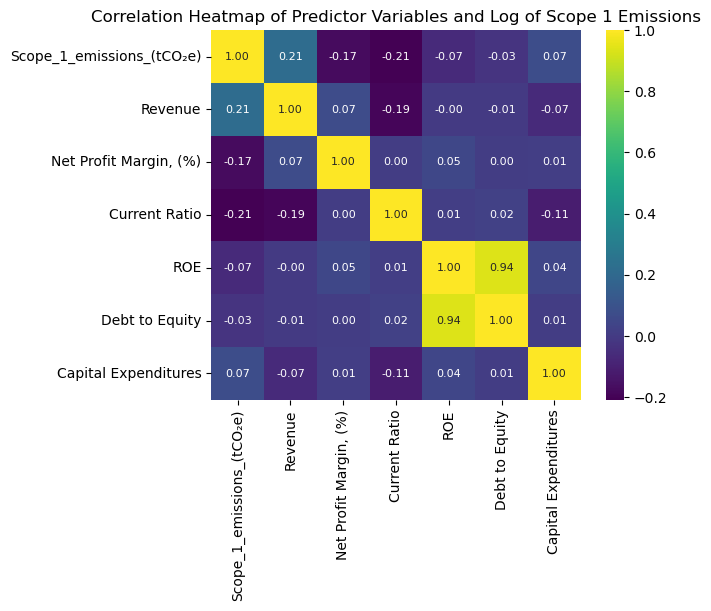

In [55]:
df_scope1 =  df_merged.drop(columns=['Scope_2_emissions_(tCO₂e)_Location',
                                      'Scope_2_emissions_(tCO₂e)_Market']).dropna().drop(columns='Company Name')
df_scope1['Scope_1_emissions_(tCO₂e)'] = np.log10(df_scope1['Scope_1_emissions_(tCO₂e)'].astype(float))

corr_matrix = df_scope1.drop(columns='Year').corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols, cmap='viridis')
hm.set_title("Correlation Heatmap of Predictor Variables and Log of Scope 1 Emissions")

plt.show()

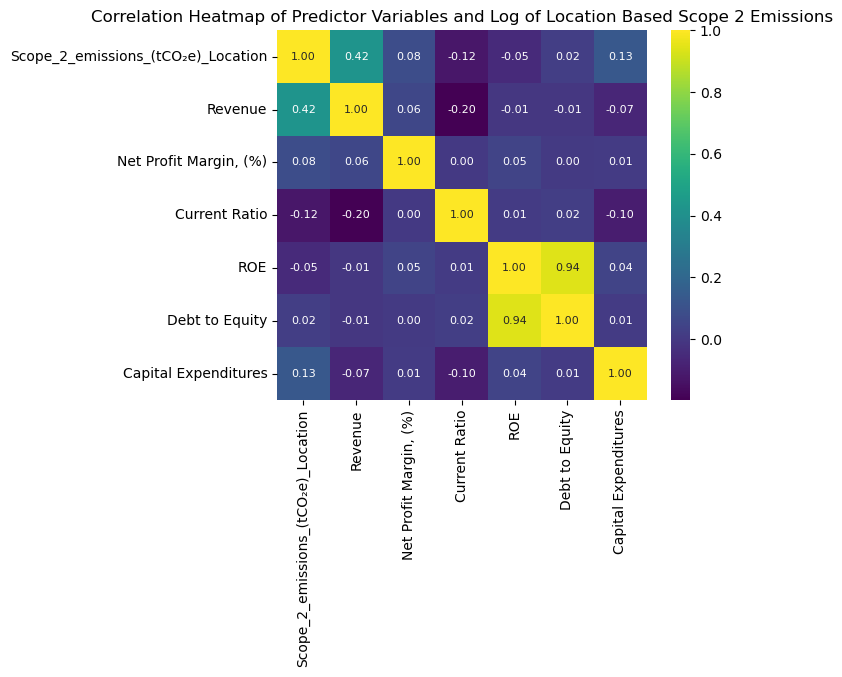

In [52]:
df_scope2 =  df_merged.drop(columns=['Scope_1_emissions_(tCO₂e)',
                                      'Scope_2_emissions_(tCO₂e)_Market']).dropna().drop(columns='Company Name')
df_scope2['Scope_2_emissions_(tCO₂e)_Location'] = np.log10(df_scope2['Scope_2_emissions_(tCO₂e)_Location'].astype(float))

corr_matrix = df_scope2.drop(columns='Year').corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols, cmap='viridis')
hm.set_title("Correlation Heatmap of Predictor Variables and Log of Location Based Scope 2 Emissions")

plt.show()

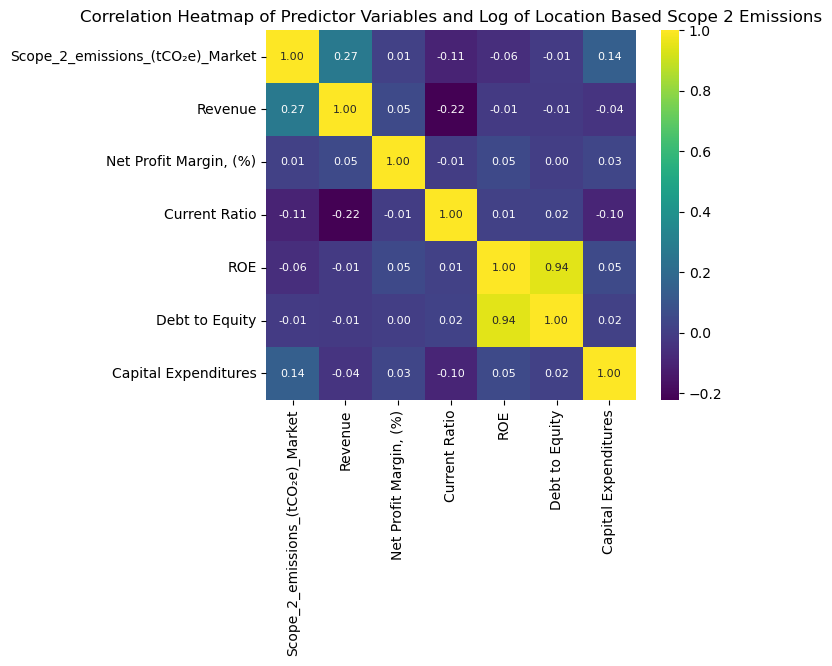

In [51]:
df_scope2 =  df_merged.drop(columns=['Scope_1_emissions_(tCO₂e)',
                                      'Scope_2_emissions_(tCO₂e)_Location']).dropna().drop(columns='Company Name')
df_scope2['Scope_2_emissions_(tCO₂e)_Market'] = np.log10(df_scope2['Scope_2_emissions_(tCO₂e)_Market'].astype(float))

corr_matrix = df_scope2.drop(columns='Year').corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols, cmap='viridis')
hm.set_title("Correlation Heatmap of Predictor Variables and Log of Market Based Scope 2 Emissions")

plt.show()